In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, '/cluster/work/climate/dnikolo/n2o')
from Glaciation_time_estimator.Data_postprocessing.Job_result_fp_generator import generate_tracking_filenames
from Glaciation_time_estimator.Auxiliary_func.config_reader import read_config

In [2]:
from derivative import dxdt

Load data

In [3]:
config = read_config(
    '/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/config_half.yaml')
t_deltas = config['t_deltas']
agg_fact = config['agg_fact']
min_temp_array, max_temp_array = config['min_temp_arr'], config['max_temp_arr']
folder_name = f"{config['start_time'].strftime(config['time_folder_format'])}_{config['end_time'].strftime(config['time_folder_format'])}"

In [4]:
sqrt_mse = 0.05628526744657018
ice_cont_crit_frac = 0.05

In [5]:
def Extract_array_from_df(series: pd.Series):
    if series.empty:
        return None
    return np.stack(series.values)

In [6]:
# Initialize an empty list to store the individual dataframes
cloud_properties_df_list = []

# Iterate over each temperature range
for i in range(len(min_temp_array)):
    cloud_properties_df_list.append([])
    min_temp = min_temp_array[i]
    max_temp = max_temp_array[i]

    # Iterate over each pole
    for pole in config["pole_folders"]:
        # Construct the file path
        fp = os.path.join(
            config['postprocessing_output_dir'],
            pole,
            folder_name,
            f"Agg_{agg_fact:02}_T_{abs(round(min_temp)):02}_{abs(round(max_temp)):02}.parquet"
        )

        # Read the parquet file into a dataframe
        df = pd.read_parquet(fp)

        # Add columns for min_temp, max_temp, and pole
        df['min_temp'] = min_temp
        df['max_temp'] = max_temp
        df['pole'] = pole
        df['Hemisphere'] = "South" if pole == "sp" else "North"
        df['Lifetime [h]'] = df['track_length'] / pd.Timedelta(hours=1)

        # Append the dataframe to the sublist
        cloud_properties_df_list[i].append(df)

# Combine all dataframes into a single dataframe
combined_df = pd.concat(
    [df for sublist in cloud_properties_df_list for df in sublist], ignore_index=True)

In [7]:
def normalize_IF_hist(row):
    lst = row['ice_frac_hist']
    normalized_length = 100
    original_indices = np.linspace(0, 1, len(lst))
    target_indices = np.linspace(0, 1, normalized_length)
    return np.interp(target_indices, original_indices, lst)


def max_normalize_IF_hist(row):
    lst = row['ice_frac_hist']
    max_val = np.max(lst)
    normalized_length = 100
    if max_val == 0:
        normalized_list = np.zeros(normalized_length)
        max_idx = None
    else:
        max_idx = np.argmax(lst)
        original_indices = np.linspace(0, max_idx, len(lst[:max_idx + 1]))
        target_indices = np.linspace(0, max_idx, normalized_length)
        normalized_list = np.interp(
            target_indices, original_indices, lst[:max_idx + 1])
        normalized_list = np.pad(
            normalized_list, (0, normalized_length - len(normalized_list)), constant_values=np.nan)
    return normalized_list, max_idx

In [8]:
norm_IF_hist_list = []
max_norm_IF_hist_list = []
Timesteps_to_max_list = []
for i, row in combined_df.iterrows():
    if i % 10000 == 0:
        print(i/10000)
    max_norm_IF_hist, Timesteps_to_max = max_normalize_IF_hist(row)
    norm_IF_hist_list.append(normalize_IF_hist(row))
    max_norm_IF_hist_list.append(max_norm_IF_hist)
    Timesteps_to_max_list.append(Timesteps_to_max)
combined_df["Timesteps_to_max"] = Timesteps_to_max_list
combined_df['max_norm_IF_hist'] = max_norm_IF_hist_list
combined_df['norm_IF_hist'] = norm_IF_hist_list

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0


Load data

In [9]:
def Extract_array_from_df(series: pd.Series):
    if series.empty:
        return None
    return np.stack(series.values)

In [10]:
cloud_properties_df_list = []
for i in range(len(min_temp_array)):
    cloud_properties_df_list.append([])
    min_temp = min_temp_array[i]
    max_temp = max_temp_array[i]
    for pole in config["pole_folders"]:
        fp = os.path.join(config['postprocessing_output_dir'], pole, folder_name,
                          f"Agg_{agg_fact:02}_T_{abs(round(min_temp)):02}_{abs(round(max_temp)):02}.parquet")
        cloud_properties_df_list[i].append(pd.read_parquet(fp))

In [11]:
class Peak:
    def __init__(self, startidx):
        self.born = self.left = self.right = startidx
        self.died = None

    def get_persistence(self, seq):
        return float("inf") if self.died is None else seq[self.born] - seq[self.died]


def get_persistent_homology(seq):
    peaks = []
    # Maps indices to peaks
    idxtopeak = [None for s in seq]
    # Sequence indices sorted by values
    indices = range(len(seq))
    indices = sorted(indices, key=lambda i: seq[i], reverse=True)

    # Process each sample in descending order
    for idx in indices:
        lftdone = (idx > 0 and idxtopeak[idx-1] is not None)
        rgtdone = (idx < len(seq)-1 and idxtopeak[idx+1] is not None)
        il = idxtopeak[idx-1] if lftdone else None
        ir = idxtopeak[idx+1] if rgtdone else None

        # New peak born
        if not lftdone and not rgtdone:
            peaks.append(Peak(idx))
            idxtopeak[idx] = len(peaks)-1

        # Directly merge to next peak left
        if lftdone and not rgtdone:
            peaks[il].right += 1
            idxtopeak[idx] = il

        # Directly merge to next peak right
        if not lftdone and rgtdone:
            peaks[ir].left -= 1
            idxtopeak[idx] = ir

        # Merge left and right peaks
        if lftdone and rgtdone:
            # Left was born earlier: merge right to left
            if seq[peaks[il].born] > seq[peaks[ir].born]:
                peaks[ir].died = idx
                peaks[il].right = peaks[ir].right
                idxtopeak[peaks[il].right] = idxtopeak[idx] = il
            else:
                peaks[il].died = idx
                peaks[ir].left = peaks[il].left
                idxtopeak[peaks[ir].left] = idxtopeak[idx] = ir

    # This is optional convenience
    # return sorted(peaks, key=lambda p: p.get_persistence(seq), reverse=True)
    # return idxtopeak, sorted(peaks, key=lambda p: -p.born, reverse=True)
    return peaks

In [12]:
class Glaciation:
    def __init__(self, min_ind, max_ind, data, timestep=15):
        self.max = data[max_ind]
        self.min = data[min_ind]
        self.min_ind = min_ind
        self.max_ind = max_ind
        self.magnitude = self.max - self.min
        self.time = (max_ind - min_ind)*timestep

In [13]:
def select_peaks(data, filt, significant_peak_tresh=0.2, glac_tresh=0.4):
    if not isinstance(data,(list,np.ndarray)): 
        data = data['ice_frac_hist']
    if filt is not None:
        filt_data = np.array(filt(data))
    else:
        filt_data = np.array(data)
    peaks = get_persistent_homology(filt_data)
    prev_peak = Peak(0)
    glac_list = []
    for peak in peaks:
        if peak.born > prev_peak.born+1:
            if peak.get_persistence(filt_data) >= significant_peak_tresh:
                # local_min = data[prev_peak.born:peak.born].min()
                # print(f"{prev_peak.born},{peak.born}")
                inter_peak_data = filt_data[prev_peak.born:peak.born]
                local_min_ind = np.where(
                    inter_peak_data == inter_peak_data.min())[0][-1]
                local_min = inter_peak_data[local_min_ind]
                if filt_data[peak.born] - local_min >= glac_tresh:
                    glac_list.append(Glaciation(
                        prev_peak.born + local_min_ind, peak.born, filt_data))
                    # print("a")
                prev_peak = peak
    return glac_list

In [14]:
from functools import partial
part_select_peaks=partial(select_peaks,filt=None)
def extract_glaciation_events(df):
    out_df = df[df["max_ice_fraction"]-(1-df["max_water_frac"])>0.5].copy()
    out_df["glac_list"] = df.apply(part_select_peaks,axis=1)
    return out_df

In [15]:
sample_df_3 = combined_df.sample(1000, random_state=2)
sample_df_3 = sample_df_3[sample_df_3["max_ice_fraction"]-(1-sample_df_3["max_water_frac"])>0.9]

In [17]:
len(resut_df)

14131

In [18]:
glac_counter=0
for i, row in resut_df.iterrows():
    glac_counter+=len(row['glac_list'])
print(sum)

<built-in function sum>


In [ ]:
result_df = extract_glaciation_events(combined_df)

In [19]:
import os
glaciations_list=[]
for i, row in result_df.iterrows():
    for glaciation in row['glac_list']:
        # glaciation.
        glaciations_list.append([i,glaciation.time,glaciation.magnitude])
glaciations_df=pd.DataFrame(glaciations_list, columns=["Cloud_ID","Time [m]","Magnitude"])
glaciations_df["Glaciation time [h]"]=glaciations_df["Time [m]"]/60
glaciations_df = pd.merge(glaciations_df,combined_df, how="left",left_on="Cloud_ID",right_index=True, validate="m:1")
output_dir = os.path.join(
        config['postprocessing_output_dir'], pole,
        config['time_folder_name'],
        f"Agg_{config['agg_fact']:02}_Glaciations"
    )
os.makedirs(os.path.dirname(output_dir), exist_ok=True)
output_dir_parq = output_dir + ".parquet"
glaciations_df.to_parquet(output_dir_parq)

In [20]:
print(glaciations_df["Glaciation time [h]"][glaciations_df["Hemisphere"]=="North"].mean())
print(glaciations_df["Glaciation time [h]"][glaciations_df["Hemisphere"]=="South"].mean())

1.6244075829383886
1.603505187048098


In [24]:
bins=np.arange(0,4,0.25)+0.001
bins

array([1.000e-03, 2.510e-01, 5.010e-01, 7.510e-01, 1.001e+00, 1.251e+00,
       1.501e+00, 1.751e+00, 2.001e+00, 2.251e+00, 2.501e+00, 2.751e+00,
       3.001e+00, 3.251e+00, 3.501e+00, 3.751e+00])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


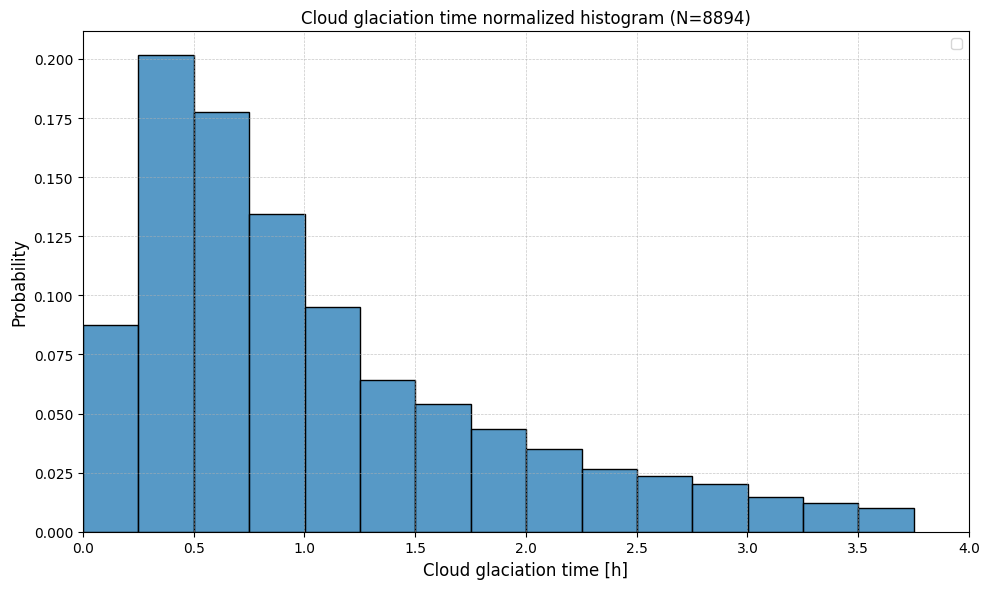

In [34]:
bins=np.arange(0,4,0.25)+0.001
f, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better readability
sns.histplot(data=glaciations_df, x="Glaciation time [h]",bins=bins,stat="probability",)
plt.ylabel("Cloud number")
ax.set_xlabel("Cloud glaciation time [h]", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.title(f"Cloud glaciation time normalized histogram (N={len(glaciations_df)})")
plt.xlim(0,4)
plt.tight_layout()
plt.savefig("/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/Result_graphs/CGT_stistics.png",dpi=400)

In [40]:
glaciations_df.keys()

Index(['Cloud_ID', 'Time [m]', 'Magnitude', 'Glaciation time [h]', 'is_liq',
       'is_mix', 'is_ice', 'max_water_frac', 'max_ice_fraction',
       'avg_size[km]', 'max_size[km]', 'min_size[km]', 'avg_size[px]',
       'max_size[px]', 'min_size[px]', 'track_start_time', 'track_length',
       'glaciation_start_time', 'glaciation_end_time', 'avg_lat', 'avg_lon',
       'start_ice_fraction', 'end_ice_fraction', 'ice_frac_hist', 'lat_hist',
       'lon_hist', 'size_hist_km', 'min_temp', 'max_temp', 'pole',
       'Hemisphere', 'Lifetime [h]', 'Timesteps_to_max', 'max_norm_IF_hist',
       'norm_IF_hist'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


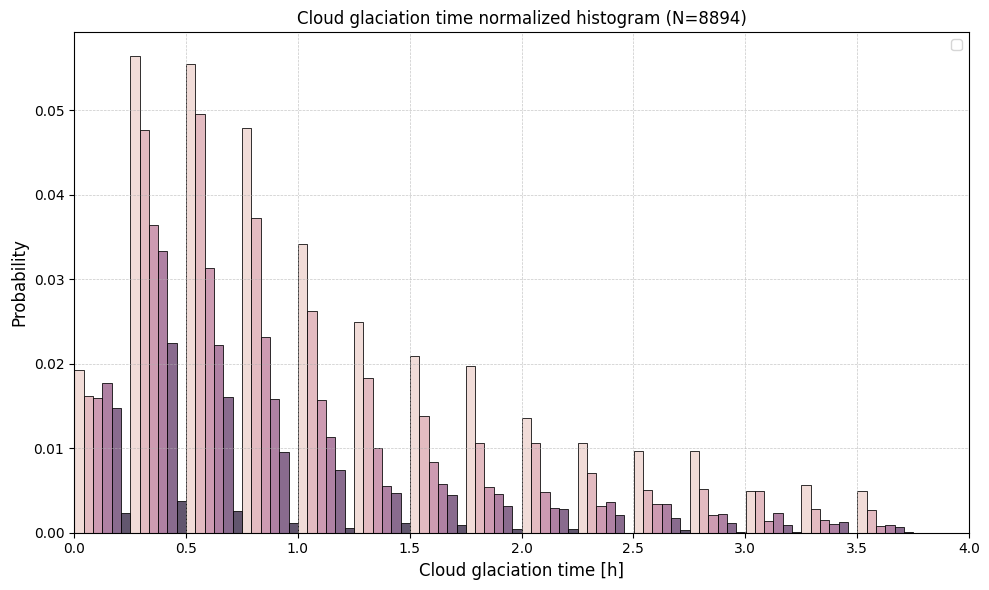

In [43]:
bins=np.arange(0,4,0.25)+0.001
f, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better readability
sns.histplot(data=glaciations_df, x="Glaciation time [h]",multiple="dodge", hue='min_temp',bins=bins,stat="probability",)
plt.ylabel("Cloud number")
ax.set_xlabel("Cloud glaciation time [h]", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# plt.tight_layout()
plt.legend()
plt.title(f"Cloud glaciation time normalized histogram (N={len(glaciations_df)})")
plt.xlim(0,4)
plt.tight_layout()
plt.savefig("/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/Result_graphs/CGT_stistics.png",dpi=400)

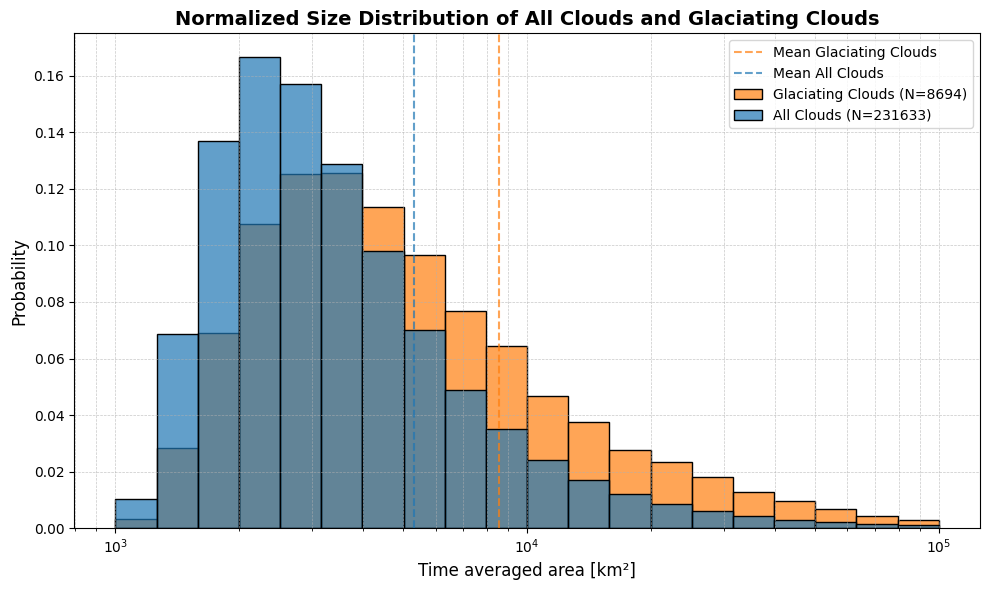

In [37]:
glaciating_clouds = glaciations_df.drop_duplicates(subset="Cloud_ID",keep="first")
# Assuming `glaciating_clouds` and `combined_df` are preloaded DataFrames
mean_glaciating = glaciating_clouds['avg_size[km]'].mean()
mean_combined = combined_df['avg_size[km]'].mean()

f, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better readability

# Plot histograms
sns.histplot(
    data=glaciating_clouds,
    ax=ax,
    x="avg_size[km]",
    log_scale=(True, False),
    binrange=(3, 5),
    bins=20,
    color=sns.color_palette()[1],
    stat="probability",
    label=f"Glaciating Clouds (N={len(glaciating_clouds)})",
    alpha=0.7  # Slight transparency for overlap visibility
)


sns.histplot(
    data=combined_df,
    ax=ax,
    x="avg_size[km]",
    log_scale=(True, False),
    binrange=(3, 5),
    bins=20,
    color=sns.color_palette()[0],
    stat="probability",
    label=f"All Clouds (N={len(combined_df)})",
    alpha=0.7
)

# Add vertical lines for means
ax.axvline(mean_glaciating, linestyle="--",color=sns.color_palette()[1], linewidth=1.5,alpha=0.7, label="Mean Glaciating Clouds")
ax.axvline(mean_combined,color=sns.color_palette()[0], linestyle="--", linewidth=1.5, alpha=0.7, label="Mean All Clouds")

# Beautify the plot
ax.set_title("Normalized Size Distribution of All Clouds and Glaciating Clouds", fontsize=14, weight="bold")
ax.set_xlabel("Time averaged area [km²]", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
filename="/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/Result_graphs/Size_hist_all_vs_glac_normalized"
plt.savefig(filename+".pdf",dpi=400)
plt.savefig(filename+".png",dpi=400)


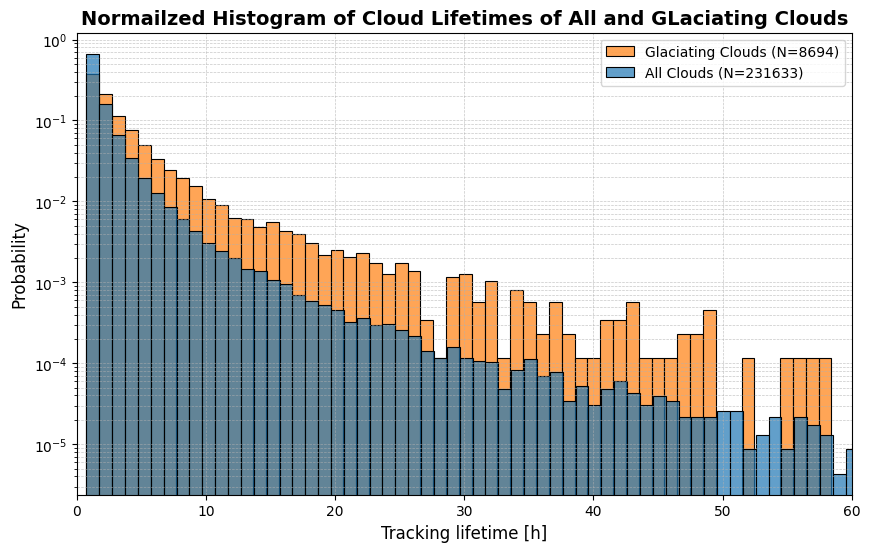

In [38]:
mean_glaciating = glaciating_clouds['Lifetime [h]'].mean()
mean_combined = combined_df['Lifetime [h]'].mean()

# Plotting
plt.figure(figsize=(10, 6))

sns.histplot(data=glaciating_clouds, x="Lifetime [h]",binwidth=1,log_scale=[False, True],color=sns.color_palette()[1], edgecolor='black', linewidth=0.8, stat="probability", alpha=0.7,label= f"Glaciating Clouds (N={len(glaciating_clouds)})")
sns.histplot(data=combined_df, x="Lifetime [h]",binwidth=1,log_scale=[False, True],color=sns.color_palette()[0], edgecolor='black', linewidth=0.8, stat="probability",alpha=0.7, label=f"All Clouds (N={len(combined_df)})",)
# plt.legend(title='Hemisphere', loc='upper right', labels=['North', 'South'])
# Labels and title
plt.xlabel("Tracking lifetime [h]", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.title("Normailzed Histogram of Cloud Lifetimes of All and GLaciating Clouds", fontsize=14, fontweight='bold')

# Customize x-axis
# plt.xlim(1e3, 1e6)
plt.yscale('log')
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
# Ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(left=0, right=60)
filename="/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/Result_graphs/Lifetime_hist_all_vs_glac_normalized"
plt.savefig(filename+".pdf",dpi=400)
plt.savefig(filename+".png",dpi=400)

In [ ]:
glaciations_df['Glaciation time [h]'].corr(glaciations_df['Lifetime [h]'])

0.5295992766272223

In [ ]:
print(combined_df["avg_size[km]"].mean(),)

5308.717339618307

<Axes: xlabel='avg_size[km]', ylabel='Probability'>

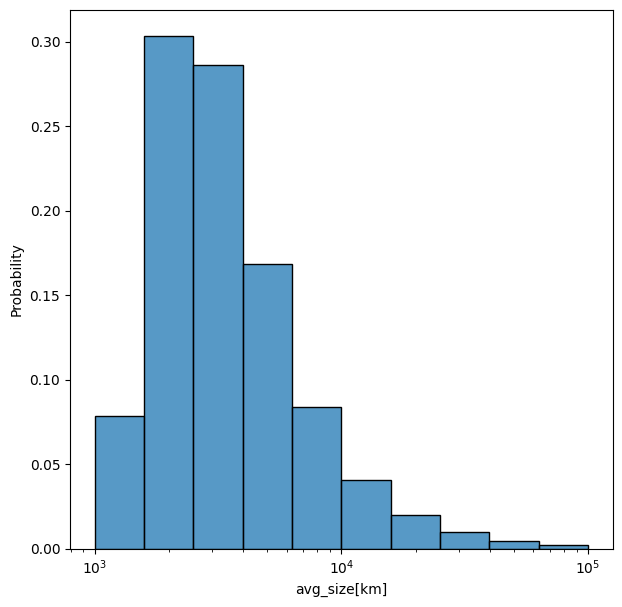

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
# ax.set(xscale="log")

# plt.show()

In [ ]:
glaciations_df

,Cloud_ID,Time [m],Magnitude,Glaciation time [h],is_liq,is_mix,is_ice,max_water_frac,max_ice_fraction,avg_size[km],...,lon_hist,size_hist_km,min_temp,max_temp,pole,Hemisphere,Lifetime [h],Timesteps_to_max,max_norm_IF_hist,norm_IF_hist
0,26856,90,0.530168,1.50,True,True,False,1.000000,0.530168,27652.556679,...,"[-25.920139980865237, -25.614617700987033, -25...","[22554.42009145403, 33106.67984522968, 21480.4...",-10,-5,np,North,18.50,58.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,27490,60,0.555538,1.00,True,True,False,1.000000,0.555538,1471.113868,...,"[-69.45706486350909, -69.60982600344819, -69.6...","[1311.1542088798967, 1573.3850506558758, 1311....",-10,-5,np,North,1.00,4.0,"[0.0, 0.006732609938290786, 0.0134652198765815...","[0.0, 0.006732609938290786, 0.0134652198765815..."
2,27783,75,0.552240,1.25,True,True,False,0.996823,0.555418,5335.959009,...,"[64.20893258320449, 64.66721600302178, 64.2089...","[9550.672946044811, 5210.716271824016, 9301.16...",-10,-5,np,North,1.25,5.0,"[0.003177206856863839, 0.003312335271828808, 0...","[0.003177206856863839, 0.003312335271828808, 0..."
3,28148,45,0.488854,0.75,True,True,False,1.000000,0.577789,2756.744007,...,"[-68.23497574399627, -68.23497574399627, -68.2...","[1262.5459818346749, 3776.1425530566385, 3292....",-10,-5,np,North,2.00,3.0,"[0.08893423080444336, 0.09252592529913392, 0.0...","[0.08893423080444336, 0.09851208279028485, 0.1..."
4,29011,105,0.842047,1.75,True,True,False,1.000000,0.842047,4787.319707,...,"[-34.0164803976376, -33.5581969778203, -32.183...","[1275.271934086138, 1434.680925846905, 7057.57...",-10,-5,np,North,2.25,9.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8889,231515,45,0.587972,0.75,False,True,False,0.777724,0.810247,2924.744556,...,"[10.436787556016561, 10.742302141377287, 10.74...","[2381.541825548191, 2173.732024865287, 1304.23...",-35,-30,sp,South,1.00,3.0,"[0.2222757339477539, 0.22934974034627278, 0.23...","[0.2222757339477539, 0.2317077424791124, 0.241..."
8890,231554,30,0.616085,0.50,False,True,True,0.636851,0.979234,11258.558784,...,"[2.6461656293179487, 3.40995209271977, 3.71546...","[4446.452169220427, 6184.620746202068, 4945.96...",-35,-30,sp,South,2.00,8.0,"[0.5933570861816406, 0.6090066416803316, 0.624...","[0.5933570861816406, 0.6090066416803316, 0.624..."
8891,231581,75,0.512339,1.25,True,True,False,0.977181,0.535158,3643.744756,...,"[-41.653449247987865, -41.653449247987865, -41...","[4345.677884801616, 4234.25024672978, 3788.539...",-35,-30,sp,South,1.25,5.0,"[0.022818932166466348, 0.02299742717584579, 0....","[0.022818932166466348, 0.02299742717584579, 0...."
8892,231598,30,0.926998,0.50,True,True,True,1.000000,0.926998,5521.946168,...,"[-6.213757346143211, -6.213757346143211, -6.82...","[1162.6987654867883, 1231.0928105154228, 1094....",-35,-30,sp,South,1.25,5.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
glaciations_df['Cloud_ID'].nunique()

8694

In [ ]:
print(sample_df_3.glac_list.iloc[0][0])

AttributeError: 'DataFrame' object has no attribute 'glac_list'

0,4
a


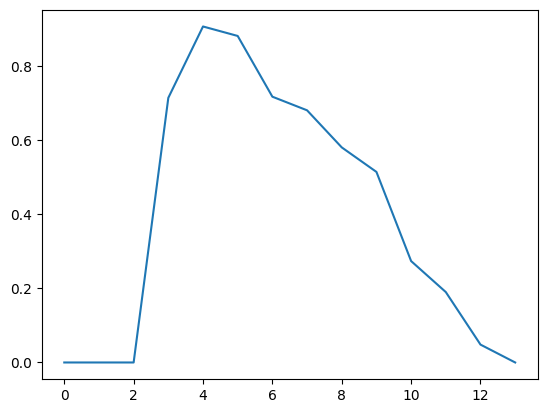

In [ ]:
plt.plot(sample_df_3['ice_frac_hist'].iloc[0])
part_select_peaks(sample_df_3.iloc[0])